In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)


2.0.0


In [2]:
import numpy as np
import pandas as pd
import csv
import pickle

import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional, concatenate, SpatialDropout1D, Dropout, GlobalMaxPooling1D,Flatten
from tensorflow.keras.optimizers import Adam

In [3]:
test_df = pd.read_csv("Data/dataset_test_no_labels.csv",sep='\t',index_col='index')

In [4]:
import pickle

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [5]:
def translate_labels(labels,inverse=False):
    convert_dict = {
      'entailment': 0,
      'neutral': 1,
      'contradiction': 2
    }
    convert_dict_inverse = {
      0: 'entailment',
      1: 'neutral',
      2: 'contradiction'
    }
    new_labels=[]
    if inverse:
        new_labels.append(convert_dict_inverse[labels])
    else:
        for label in labels:
            new_labels.append(convert_dict[label])
    
    return new_labels

In [11]:
vocabulary_size=1000
embedding_size = 64
max_sequence_length = 300
hidden_size = 64

In [12]:
premise = tf.keras.Input(shape=(max_sequence_length), name='Premise')        # Sequence of ints
hypothesis = tf.keras.Input(shape=(max_sequence_length), name='Hypothesis')  # Sequence of ints

emb_1 = Embedding(vocabulary_size,embedding_size)(premise)  
emb_1 = SpatialDropout1D(0.2)(emb_1)
emb_1 = Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(emb_1)
emb_1 = Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(emb_1)
emb_1 = Dropout(0.25)(emb_1)
emb_1 = GlobalMaxPooling1D()(emb_1)
     
emb_2 = Embedding(vocabulary_size,embedding_size)(hypothesis)
emb_2 = SpatialDropout1D(0.2)(emb_2)
emb_2 = Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))(emb_2)
emb_2 = Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(emb_2)
emb_2 = Dropout(0.25)(emb_2)
emb_2 = GlobalMaxPooling1D()(emb_2)

x = concatenate([emb_1, emb_2], axis = -1)
x = Dense(hidden_size, activation='relu')(x)
x = Dense(3, activation='softmax')(x)

model = Model(inputs=[premise, hypothesis], outputs=x)
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [13]:
checkpoint_path = "training_3/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Premise (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
Hypothesis (InputLayer)         [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 300, 64)      64000       Premise[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 300, 64)      64000       Hypothesis[0][0]                 
______________________________________________________________________________________________

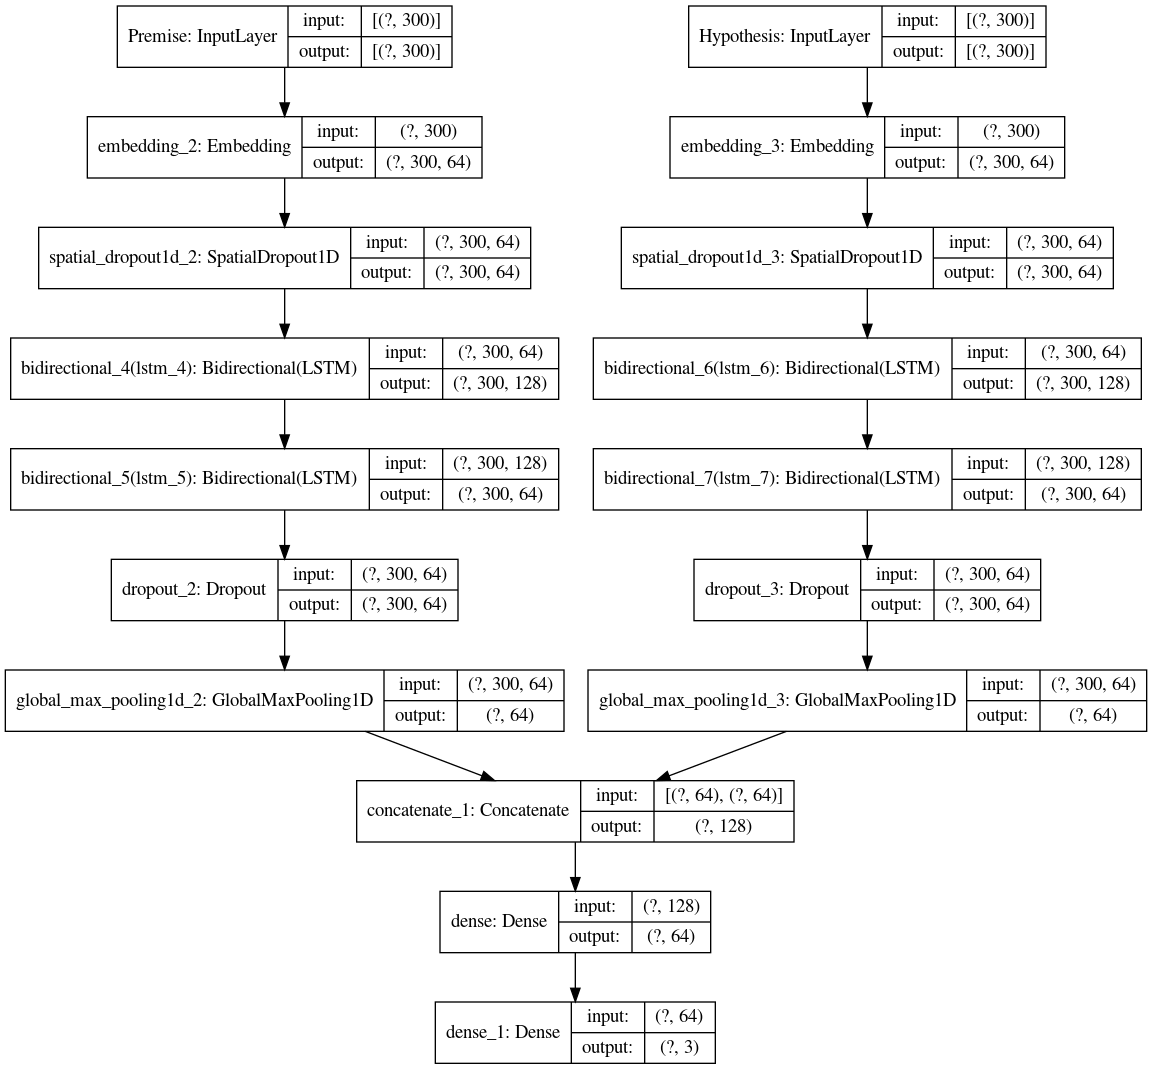

In [15]:
tf.keras.utils.plot_model(model, 'model_2.png', show_shapes=True)

In [16]:
test_sentence_1_tok = tokenizer.texts_to_sequences(test_df["sentence_1"])
test_sentence_2_tok = tokenizer.texts_to_sequences(test_df["sentence_2"])

test_sentence_1_pad = sequence.pad_sequences(test_sentence_1_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")
test_sentence_2_pad = sequence.pad_sequences(test_sentence_2_tok,maxlen=max_sequence_length, dtype='int32', truncating="post",padding="post")

In [17]:
tmp = []
tmp.append(test_sentence_1_pad)
tmp.append(test_sentence_2_pad)

X_test = np.array(tmp)

In [18]:
predict = model.predict([X_test[0],X_test[1]],verbose=True)

19647/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [19]:
pred_labels=pd.DataFrame(columns=["index","label"])

for index,pred in enumerate(predict):
    real_label = translate_labels(np.round(np.argmax(pred)),inverse=True)
    real_label = str(real_label).strip('[]').replace("'","")
    pred_labels = pred_labels.append({'index':index, 'label':real_label},ignore_index=True)

In [20]:
pred_labels.to_csv('submission.csv', index = False)

In [21]:
TableBIS = pd.read_csv("submission.csv", sep="\t")
print(TableBIS)

               index,label
0             0,entailment
1             1,entailment
2                2,neutral
3          3,contradiction
4          4,contradiction
...                    ...
19642  19642,contradiction
19643     19643,entailment
19644  19644,contradiction
19645        19645,neutral
19646        19646,neutral

[19647 rows x 1 columns]
